# Model Evaluation

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
os.chdir('../')
print("Current working directory:", os.getcwd())

Current working directory: f:\GP\sem 2\MIMO GAN\project


In [3]:
from src.model_builder import Generator
from eval import *

In [4]:
# simulation params
L = 23
Nr = Nt = 4
NUM_ANTENNA_PAIRS = Nr * Nt
z_dim = 50
EMBED_DIM = 4
HIDDEN_DIM = 100
BATCH_SIZE = 12000

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Create an instance of the model
model = Generator(Nr, Nt, L, z_dim, EMBED_DIM, HIDDEN_DIM).to(device)
model = model.double()
# Load the state dictionary
state_dict = torch.load(os.path.join('models', 'G_B0L1_BSZ512_EMB4_Z50.pt'))
model.load_state_dict(state_dict)

model.eval()

Generator(
  (embedding): Linear(in_features=16, out_features=4, bias=True)
  (main): Sequential(
    (0): Linear(in_features=54, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=46, bias=True)
  )
)

## Loading Data

### Test Data

In [7]:
train_dataset_path =  os.path.join("Dataset", "test_data_TDL_A.mat")
var_name = "ch_test_data"
H_test = get_test_data(train_dataset_path, var_name)

### Generated Data

In [8]:
# get a batch of generated data
H = get_batch_generated(model, BATCH_SIZE, Nr, Nt, L, z_dim, device)

In [9]:
power = torch.sum(torch.pow(torch.abs(H),2), dim=(1,3), keepdim=True)
H_n = H / torch.sqrt(power)

## Visualizing Data Samples

In [10]:
delay_spread = 300e-9
yaml_path = os.path.join("config", "normalized_delays.yaml")
var_name = "normalized_delays"
delays_sec = get_path_delays(yaml_path, var_name, delay_spread)

### Test Data

In [11]:
H_sample = H_test[100,:,:,:]
H_sample = np.abs(H_sample)**2
H_sample = 10 * np.log10(H_sample)

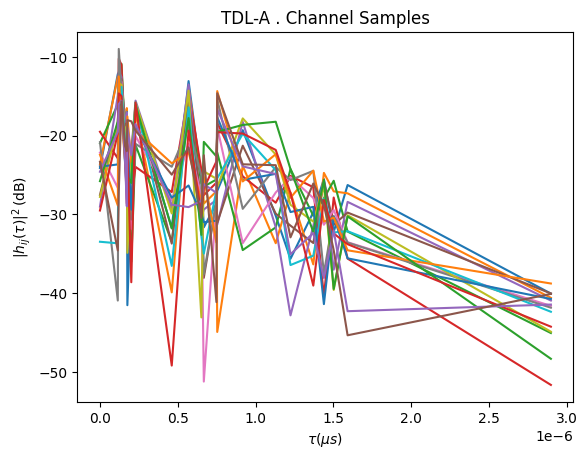

In [12]:
plt.figure()
for i in range(Nr):
    for j in range(Nt):
        plt.plot(delays_sec, H_sample[i,j,:])

plt.title("TDL-A . Channel Samples")
plt.xlabel(r"$\tau (\mu s)$")
plt.ylabel(r"$|h_{ij}(\tau)|^2 \, (\text{dB})$")
plt.show()

### Generated Data

In [13]:
H_s = H_n[0,:,:,:]
H_p = H_s.cpu().numpy()
H_p = np.abs(H_p)**2
H_p = 10 * np.log10(H_p)

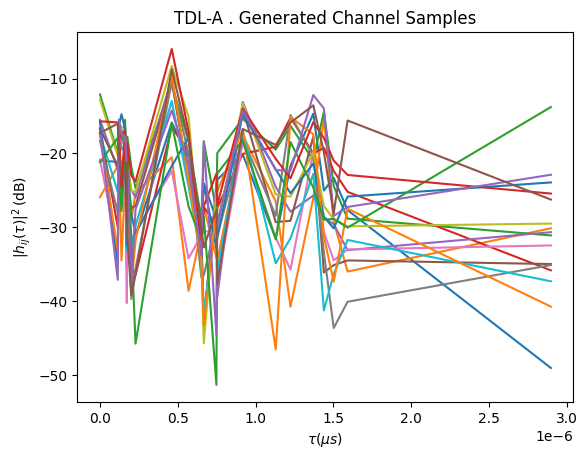

In [14]:
plt.figure()
for i in range(Nr):
    for j in range(Nt):
        plt.plot(delays_sec, H_p[i,j,:])

plt.title("TDL-A . Generated Channel Samples")
plt.xlabel(r"$\tau (\mu s)$")
plt.ylabel(r"$|h_{ij}(\tau)|^2 \, (\text{dB})$")
plt.show()

## Correlation Analysis

### Tx-side Correlations

In [15]:
H_c = H.cpu().numpy()
r = 0.3

R_GT_T = np.array([[1,          r**(1/9), r**(4/9), r],
              [r**(1/9),   1,        r**(1/9), r**(4/9)],
              [r**(4/9),   r**(1/9), 1,        r**(1/9)],
              [r,          r**(4/9), r**(1/9), 1]])

R_GT_T = np.round(R_GT_T, 2)

R_G_T = get_corr(H_c, True)

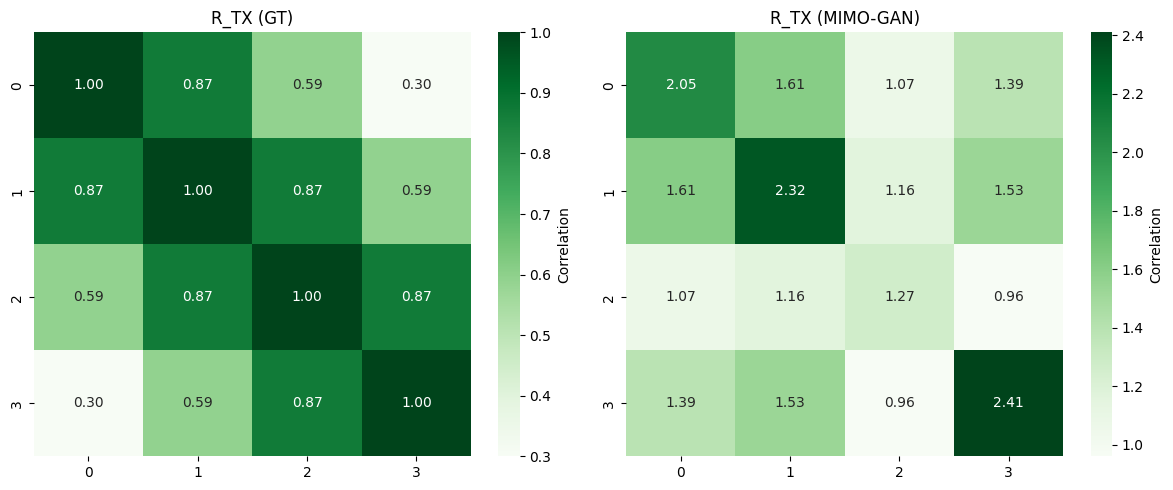

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting R_GT
sns.heatmap(R_GT_T, ax=ax[0], cmap='Greens', annot=True, fmt=".2f", cbar=True, cbar_kws={'label': 'Correlation'})
ax[0].set_title('R_TX (GT)')

# Plotting R_MIMO_GAN
sns.heatmap(R_G_T, ax=ax[1], cmap='Greens', annot=True, fmt=".2f", cbar=True, cbar_kws={'label': 'Correlation'})
ax[1].set_title('R_TX (MIMO-GAN)')

plt.tight_layout()
plt.show()

In [17]:
mae = np.mean(np.abs(R_GT_T - R_G_T))
print("Mean Absolute Error (MAE):", np.round(mae,2))

Mean Absolute Error (MAE): 0.14


### Rx-side Correlations

In [18]:
r = 0.3874

R_GT_R = np.array([[1,          r**(1/9), r**(4/9), r],
              [r**(1/9),   1,        r**(1/9), r**(4/9)],
              [r**(4/9),   r**(1/9), 1,        r**(1/9)],
              [r,          r**(4/9), r**(1/9), 1]])

R_GT_R = np.round(R_GT_R, 2)

R_G_R = get_corr(H_c, False)

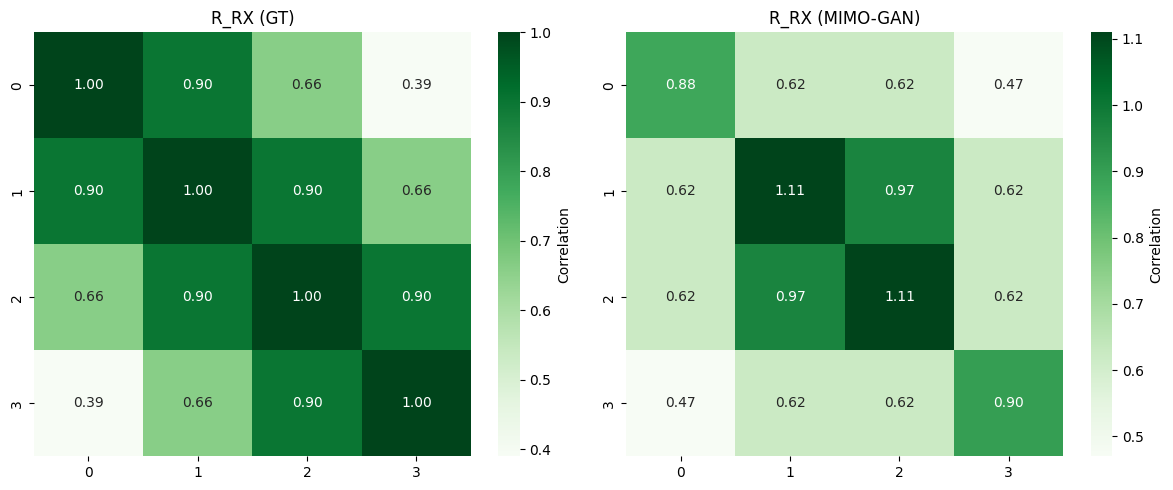

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting R_GT
sns.heatmap(R_GT_R, ax=ax[0], cmap='Greens', annot=True, fmt=".2f", cbar=True, cbar_kws={'label': 'Correlation'})
ax[0].set_title('R_RX (GT)')

# Plotting R_MIMO_GAN
sns.heatmap(R_G_R, ax=ax[1], cmap='Greens', annot=True, fmt=".2f", cbar=True, cbar_kws={'label': 'Correlation'})
ax[1].set_title('R_RX (MIMO-GAN)')

plt.tight_layout()
plt.show()

In [20]:
mae = np.mean(np.abs(R_GT_R - R_G_R))
print("Mean Absolute Error (MAE):", np.round(mae,2))

Mean Absolute Error (MAE): 0.13


## Total Power

### Test Data

In [17]:
average_power_dB_per_link_GT, average_total_power_dB_GT = compute_total_power_dB(torch.from_numpy(H_test))
print(average_power_dB_per_link_GT)
print(average_total_power_dB_GT)

tensor([[-6.2962, -6.2964, -6.3008, -6.3026],
        [-6.3007, -6.2912, -6.2922, -6.2931],
        [-6.3044, -6.3036, -6.3068, -6.3110],
        [-6.3048, -6.3194, -6.3342, -6.3449]], dtype=torch.float64)
tensor(-6.3064, dtype=torch.float64)


### Generated Data

In [24]:
average_power_dB_per_link_G, average_total_power_dB_G = compute_total_power_dB(H_n)
print(average_power_dB_per_link_G)
print(average_total_power_dB_G)

tensor([[-7.5566, -7.3833, -6.1611, -6.7305],
        [-5.4345, -5.3208, -6.5529, -6.0555],
        [-5.3519, -5.4142, -6.5672, -6.0068],
        [-7.3096, -7.3190, -6.1417, -6.8177]], device='cuda:0',
       dtype=torch.float64)
tensor(-6.3827, device='cuda:0', dtype=torch.float64)


In [25]:
total_power_mae = np.abs((10 ** (average_total_power_dB_GT.item() / 10)) - (10 ** (average_total_power_dB_G.item() / 10)))
total_power_mae_dB = 10 * np.log10(total_power_mae)
print("Mean Absolute Error (MAE):", np.round(total_power_mae, 3))
print("Mean Absolute Error in dB (MAE):", np.round(total_power_mae_dB,3))

Mean Absolute Error (MAE): 0.004
Mean Absolute Error in dB (MAE): -23.896


## Average Delay

### Test Data

In [21]:
average_delay_per_link_GT, overall_average_delay_GT = compute_average_delay_per_link(torch.from_numpy(delays_sec), torch.from_numpy(H_test))
print(average_delay_per_link_GT)
print(overall_average_delay_GT)

tensor([[2.7774e-07, 2.7755e-07, 2.7765e-07, 2.7746e-07],
        [2.7810e-07, 2.7757e-07, 2.7752e-07, 2.7741e-07],
        [2.7811e-07, 2.7795e-07, 2.7786e-07, 2.7778e-07],
        [2.7787e-07, 2.7835e-07, 2.7863e-07, 2.7881e-07]], dtype=torch.float64)
tensor(2.7790e-07, dtype=torch.float64)


### Generated Data

In [22]:
average_delay_per_link_G, overall_average_delay_G = compute_average_delay_per_link(torch.from_numpy(delays_sec), H_n.cpu())
print(average_delay_per_link_G)
print(overall_average_delay_G)

tensor([[7.3206e-07, 6.5666e-07, 6.6178e-07, 7.6538e-07],
        [4.6600e-07, 4.7766e-07, 4.8532e-07, 6.2586e-07],
        [4.6772e-07, 4.7617e-07, 4.8090e-07, 6.2228e-07],
        [7.4360e-07, 6.6053e-07, 6.6166e-07, 7.6283e-07]], dtype=torch.float64)
tensor(6.0915e-07, dtype=torch.float64)


In [23]:
avg_delay_mae = np.abs(overall_average_delay_G.item() - overall_average_delay_GT.item())
print(avg_delay_mae)

3.3125383878824606e-07


## RMS Delay Spread

### Test Data

In [27]:
rms_delay_per_link_GT, overall_average_rms_delay_GT = compute_rms_delay_per_link(torch.from_numpy(delays_sec), torch.from_numpy(H_test))
print(rms_delay_per_link_GT)
print(overall_average_rms_delay_GT)

tensor([[2.9635e-07, 2.9602e-07, 2.9586e-07, 2.9595e-07],
        [2.9638e-07, 2.9590e-07, 2.9591e-07, 2.9600e-07],
        [2.9628e-07, 2.9622e-07, 2.9635e-07, 2.9664e-07],
        [2.9611e-07, 2.9646e-07, 2.9693e-07, 2.9753e-07]], dtype=torch.float64)
tensor(2.9631e-07, dtype=torch.float64)


### Generated Data

In [28]:
rms_delay_per_link_G, overall_average_rms_delay_G = compute_rms_delay_per_link(torch.from_numpy(delays_sec), H_n.cpu())
print(rms_delay_per_link_G)
print(overall_average_rms_delay_G)

tensor([[6.0477e-07, 5.5074e-07, 5.6372e-07, 5.3373e-07],
        [3.6730e-07, 3.6248e-07, 4.3149e-07, 4.3672e-07],
        [3.6719e-07, 3.6145e-07, 4.2972e-07, 4.3509e-07],
        [6.0788e-07, 5.5620e-07, 5.6765e-07, 5.3082e-07]], dtype=torch.float64)
tensor(4.8168e-07, dtype=torch.float64)


In [29]:
avg_delay_mae = np.abs(overall_average_rms_delay_GT.item() - overall_average_rms_delay_G.item())
print(avg_delay_mae)

1.853791666661576e-07
